<H1>Numerisk løsning av den tidsuavhengig Schrödingerligningen</H1>

<p>Notatboken og tilhørende kildekode ligger på <a href="https://github.com/kaprests/Numerical-1D-TISE">GitHub.</a></p>

<H2>Gruppe 21: Henrik E. V. Skaldebø og Knut Andre G. Prestsveen</H2>

<H2>Sammendrag</H2>
<p>Denne notatboken prosjekt nummer to i faget TMA4320, og øving i faget TFY4215 ved Norges tekniske og naturvitenskapelige universitet. Den tar for seg nummerisk løsning av den tidsuavhengige Schrödingerligningen (TUSL) for ikke-vekselvirkende elektroner i ulike potensialer som modellerer partikkel i boks, atomer, molekyler og krystaller i én dimensjon.</p>

<H2>Introduksjon</H2>
<p>What we do, why it is cool and how it wørks</p>
<p>Vi ser som nevnt på løsninger av TUSL én dimensjon, for ikke-vekselvirkende elektroner, som også adlyder Pauliprinsippet (write some moar later)</p>

<h3>Numerisk løsning av (1D) TUSL</h3>
TUSL i en dimensjon er

**TUSL**,

Det taes utgangspunkt i bokspotensialet, altså at partikkelen kan oppholde seg på et endelig område langs x-aksen, avgrenset av harde vegger(uendelig potensiale) i endepunktene $x=0$ og $x=L$. Partikkelens posisjon på dette området diskretiseres i $N$ mulige verdier, slik at løsningene går fra $\psi(x)$ til $\psi(n\Delta x)$, hvor $n = 0, 1, 2, ... , N, N+1$. I endepunktene er bølgefunskjonen null på grunn av kontinuitet i overgangen ved veggene, siden bølgefunksjonen må være null der potensialet er uendelig. Med diskret posisjon og operatorer kan TUSL da skrives som de $N$ differanseligningene

**TUSL diskret**.

Som igjen kan skrives på matriseform

**TUSL matrise**; n = 1,2,3, ... , N

hvor $\mathbf{H}$ er $NxN$ matrise med diagonalelementer $MAIN_DIAG_YO$ og elementene $secon_diag_yo$ over og under diagonalen, og $E$ er energi-/egenverdier. Denne egenverdiligningen har ikke-trivielle løsninger kun når $det(put in determ eqn)$, hvor $I$ er identitetsmatrisen. $E\mathbf{I}$ er da en $NxN$ matrise med energiverdiene langs diagonalen, og poenget er at de numeriske løsningene for bølgefunksjonene og energinivåene er gitt av hhv. egenvektorene og egenverdiene til $\mathbf{H}$-matrisen.





In [49]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.constants import hbar, m_e, eV
from scipy.linalg import eigh_tridiagonal

hbar *=1e9 #Plancks constant, scaled for nm as recomended by mr. MAN ;)
L_well = 1 #nm - length/width of each potential well
V0 = 3 #eV - depth of the wells
n_well = 10 # number of datapoints per well
n_bar = 5 # number of datapoints per barrer
fact = (hbar**2)/(m_e*eV) # precalculated factor to lessen float operations


# Constructs a potential with num_w number of wells
def potential(num_w, V0=-V0):
	V1 = np.array([[V0]*n_well + [0]*n_bar]).flatten() # one well with barrier to the right
	V_mid = np.tile(V1, num_w) 
	V_front = np.zeros(n_well*10)
	V_back = np.zeros(n_well*10 - n_bar)
	V = np.append(V_front, V_mid)
	V = np.append(V, V_back)
	well_voids = max(num_w -1, 0)
	L = num_w*L_well + well_voids*n_bar*(L_well/n_well) + 20*L_well
	return V, L # returns the final potential and length of the system
	

# Calculates eigenenergies and eigenvector(wave functions)
def analyze(num_w, add_E_lvls = 0):
	V, L = potential(num_w)
	n = len(V)
	delta_x = L/(n+1)
	x_vec = np.linspace(0, L, n)
	if num_w == 0:
		num_E_lvls = 3 + add_E_lvls
	else:
		num_E_lvls = 3*num_w + add_E_lvls
	
	main_diag = np.ones(n) * fact/(delta_x**2) + V
	off_diag = np.ones(n-1) * -fact/(2*delta_x**2)

	energies, wave_funcs = eigh_tridiagonal(main_diag, off_diag)
	wave_funcs = wave_funcs.T

	return energies, wave_funcs, x_vec, num_E_lvls, L, V


def plot_well_wave_funcs(num_w, add_E_lvls=0):
    energies, wave_funcs, x_vec, iter_lim, L, V = analyze(num_w, add_E_lvls)
    scale = V0/2
    if num_w == 0:
        scale = 0.5
    for i in range(iter_lim):
        plt.plot([0,L], [energies[i]]*2)
        plt.plot(x_vec, V)
        plt.plot(x_vec, energies[i] + wave_funcs[i]*scale)
    plt.title("Numerical - Wells: " + str(num_w) + ", Energy-levels: " + str(iter_lim))
    plt.xlabel("Width (nm)")
    plt.ylabel("Energy (eV)")
    plt.savefig("figW" + str(num_w) + "E" + str(iter_lim) + ".png")
    plt.show()


# Computes and plots energy band widths for potentials with lower to upper number of wells
def band_widths(lower, upper):
	x_vec = np.linspace(lower, upper, upper-lower)
	band_widths = np.zeros([3, upper - lower])
	for i in range(lower, upper):
		energies,_,_,_,_,_ = analyze(i)
		for j in range(3):
			band_widths[j][i - lower] = np.absolute(energies[i*j] - energies[(j+1)*i -1])

	for i in range(3):
		plt.plot(x_vec, band_widths[i])
	#plt.savefig("bw.pdf")
	plt.show()


# Numerically computes the energies from the analytic solutions of TISE and prints them
def trancendent_sol():
	a = L_well/2
	
	z0 = (a/hbar)*np.sqrt(2*m_e*V0*eV)
	
	RS = lambda z : np.sqrt((z0/z)**2 -1)
	RS_asym = lambda z : -1/(np.sqrt((z0/z)**2 -1))
	LS = lambda z : np.tan(z)

	z_tan = np.linspace(0.1,4.5, 1000)
	z = np.linspace(0.1,4.05, 1000)
	for i in range(len(z_tan)):
		if np.absolute(LS(z_tan[i])) > 9:
			z_tan[i] = np.nan

	f = lambda z : RS(z) - LS(z)
	f_asym = lambda z : RS_asym(z) - LS(z)
	
	z_zeros = np.array([1.2, 3.5])
	z_zeros = fsolve(f, z_zeros)

	z_zeros_asym = 2
	z_zeros_asym = fsolve(f_asym, z_zeros_asym)
	
	z_zeros = np.array([z_zeros[0], z_zeros_asym[0], z_zeros[1]])

	E = lambda z : ((z*hbar)**2)/((a**2)*2*m_e*eV) - V0 # Okay, still not perf. div by a**2 arbitrarily to get the energies to match, but someone should figure this out later.
	for i in range(len(z_zeros)):
		print("Energi #" + str(i+1) + ": ", E(z_zeros[i]))

	energies,_,_,_,_,_ = analyze(1)
	for i in range(3):
		print("Num energies: ", energies[i])

	plt.ylim(-5, 5)
	plt.plot(z_tan, LS(z_tan))
	plt.plot(z, RS(z))
	plt.plot(z, RS_asym(z))
	#plt.savefig("trancend_plot.pdf")
	plt.show()
	
	#return z_zeros


### <h3>Oppgave 1 - Partikkel i boks</h3>
    
For å teste algoritmen, undersøkes først en uendelig dyp potensialbrønn med potensial $V(x)=0$ for $0<x<L$. Også betegnet som en partikkel i boks, hvor potensialet er uendelig utenfor og 0 innenfor boksen. Den tidsuavhengige schrödingerligningen har følgende analytiske funksjoner for en slik potensialbrønn

$$\psi_j (x) = \sqrt{2/L}\sin k_jx$$

med egenenerginivå

$$E_j = \frac{\hbar^2 k_j^2}{2m}$$

Både $\psi_j$ og $E_j$ bruker bølgetallene $k_j$, med $j = 1, 2, 3...$

$$k_j = \frac{j \pi}{L}$$

Koden i den følgende cellen beregner disse analytiske løsningene, plotter og lagrer dem i en pdf.

In [52]:
#analytisk løsning

L = 20 #nm
n = 100
k_j = np.pi/L
energy_factor = (hbar**2)/(2*m_e)
x = np.linspace(0, L, n)
scale = 0.15 #for å skalere bølgefunksjonene

def wave_func(j, x):
        return np.sqrt(2/L)*np.sin(k_j*j*x)

def plot_analytic(levels):
    for j in range(1, levels+1):
        energy = energy_factor*((k_j*j)**2)/eV
        plt.plot([0, L], [energy]*2)
        plt.plot([0, L], [0]*2) #potensialnivået ved V=0
        plt.plot(x, energy + wave_func(j, x)*scale)
    plt.xlabel("Width (nm)")
    plt.ylabel("Energy (eV)")
    plt.title("Analytical - Wells: 0, Energy-levels: " + str(levels))
    plt.savefig("analyticW0E" + str(levels) + ".pdf")
    plt.show()

Figuren nedenfor viser de analytiske løsningene, funnet ved <font color=blue>plot_analytic()</font> for tre nivå, samt de numeriske, ved <font color=blue>plot_well_wave_funcs()</font> for ingen brønner. Amplituden for de analytiske bølgefunksjonene er vanligvis $\sqrt{2/L}$, men er her skalert ned for å samsvare bedre med de numeriske løsningene. Energinivåene fra de numeriske løsningene stemmer her meget bra med det analytiske resultatet. Ved å se på bølgefunksjonene som korresponderer med hvert energinivå stemmer også dette ettersom kurvene har samme antall ekstremalpunkt Grunnen til at vi ved tredje energinivå får forskjellig antall maksima/minima kommer av at scipy-funksjonen <font color=blue>eigh_tridiagonal()</font> ikke nødvendigvis ser forskjell på de to tilfellene(blir det riktig å si?? :o ).

- Er egenfunksjonene ortogonale og normerte (ortonormerte)?<br/>
Det finnes kun en egenfunksjon for hver egenenergiverdi som tilsier at funksjonene er ortogonale. Dette kommer også av at vi kun ser på endimensjonale situasjoner som betyr at energiegenverdiene ikke kan være degenererte, det vil si at flere egenfunksjoner svarer til én egenverdi.
- Danner egenfunksjonene et fullstendig sett?



![title](oppg1comparison.png)

<h2>Oppgave 2 - Atomer</h2>

a)<br/>
3 bundne tilstander funnet med å bruke analyze for 1 brønn og 3 energinivå.
- Har bølgefunksjonene fornuftige egenskaper med hensyn til symmetriegenskaper og bølgelengder i det klassisk tillate området?
- Sammenlign de beregnede energinivåene med analytiske løsninger.
![title](figW1E3.png)
3 bundne tilstander med en bundet tilstand på toppen ved å bruke analyze for 1 brønn og 4 energinivå.
- Gir beregningene et "kvasikontinuerlig" spektrum av ubundne tilstander med med E>0. Vis at bølgelengdene er i samsvar med elektronets kinetiske energi i og utenfor brønnområdet.
![title](figW1E4.png)
b)


<h2>Oppgave 3 - Molekyler</h2>




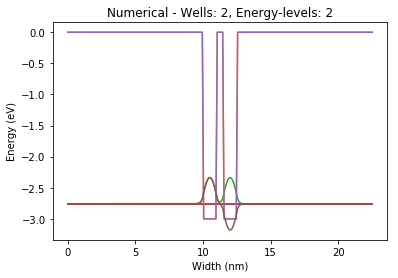

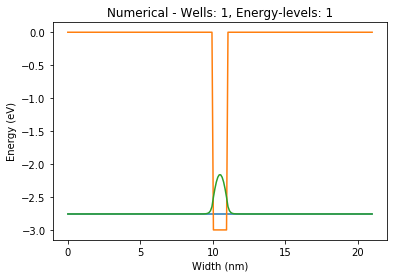

Energi dobbelbrønn: 4.658914855550385 eV
Energi enkelbrønn: 3.2964827857654053 eV
Bindingsenergi: 1.9340507159804252 eV


In [61]:
plot_well_wave_funcs(2,-4)
plot_well_wave_funcs(1, -2)

_,energies_2_well,_,_,_,_ = analyze(2, -4)
_,energies_1_well,_,_,_,_ = analyze(1, -2)
bind_energy = np.absolute(2*np.sum(energies_1_well[:1]) - np.sum(energies_2_well[:2]))

print("Energi dobbelbrønn:", np.sum(energies_2_well[:2]), "eV")
print("Energi enkelbrønn:", np.sum(energies_1_well[:1]), "eV")
print("Bindingsenergi:", bind_energy, "eV")


<h2>Oppgave 4 - Krystaller</h2>

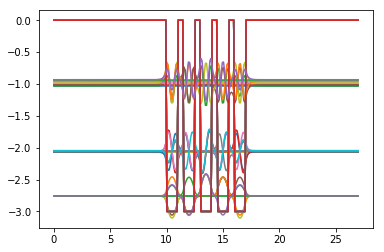

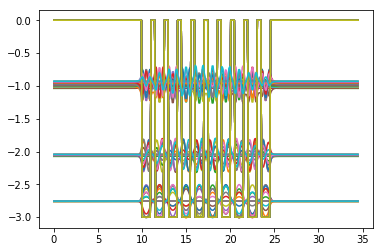

In [29]:
plot_well_wave_funcs(5)
plot_well_wave_funcs(10)

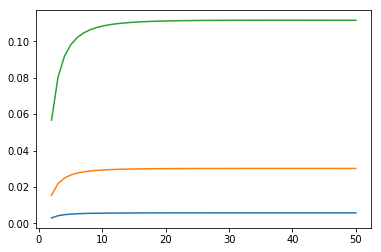

In [9]:
band_widths(2,50)